<a href="https://colab.research.google.com/github/rieldata1/deep-clustering-rails/blob/main/Deep_Clustering_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurar GPU y activar high-RAM**

In [62]:
# Montar Drive
from google import colab
colab.drive.mount('/content/drive')
print("")

# Configurar GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Activar high-RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Tue Sep  2 22:10:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   74C    P0             35W /   72W |    2201MiB /  23034MiB |      0%      Default |
|         

# **Deep_Clustering: carga NPZ + AE + K-sweep + DEC (+ IDEC)**
* Este notebook consumirá los NPZ generados por "Scalograms".


## **0. Preeliminares**

In [63]:
# ============================================================
#  PRELIMINARES: Parámetros + Imports + Runtime/Device + Utils
#  Este notebook consume los .npz generados por "Scalograms".
# ============================================================

# -----------------------------
# PARÁMETROS (ajusta aquí)
# -----------------------------
BASE_DIR           = "/content/drive/MyDrive/Deep_Cluster"
EXPERIMENTS_DIR    = f"{BASE_DIR}/experiments"

# Datos
PRELOAD_DATA       = True         # intentar precargar todos los .npz si caben en RAM
PRELOAD_MAX_GB     = 4.0          # umbral aprox para decidir precarga
IMG_NORMALIZE_AGAIN= False        # renormalizar [0,1] al vuelo (en general no hace falta)

# DataLoader
BATCH_AE           = 64
BATCH_EMB          = 128
BATCH_DEC          = 64
NUM_WORKERS        = 2
PIN_MEMORY         = True
PERSISTENT_WORKERS = True

# Modelo / Entrenamiento
LATENT_DIM         = 256
BACKBONE           = "large"       # 'small' | 'base' | 'large'
DROPOUT_P          = 0.0

AE_EPOCHS          = 25
AE_LR              = 1e-3
AE_WD              = 1e-5
AE_LOSS            = "l1"         # 'l1' o 'mse'
USE_AMP            = True         # mixed precision en GPU (dtype explícito)

# Barrido de K
K_MIN              = 3
K_MAX              = 10
K_FIXED            = None         # si lo fijas, salta el barrido (ej. 4)
K_RANDOM_STATE     = 2025

# DEC
DEC_EPOCHS         = 40
DEC_LR             = 1e-4
DEC_WD             = 0.0
DEC_UPDATE_INT     = 1
DEC_TOL            = 1e-3

# IDEC (opcional) — lo añadiremos en una celda siguiente si lo activas
RUN_IDEC           = False
IDEC_EPOCHS        = 40
IDEC_LR            = 1e-4
IDEC_WD            = 0.0
IDEC_LAMBDA_REC    = 1e-2
IDEC_UPDATE_INT    = 1
IDEC_TOL           = 1e-3

# Visualización / Guardado
RUN_TSNE_2D        = True
TSNE_PERPLEXITY    = 30
SEED               = 2025
SAVE_ARTIFACTS     = True

# -----------------------------
# IMPORTS
# -----------------------------
import os, time, csv, math, gc, json, random, glob, bisect
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm  # no 'auto' → evita widgets (GitHub render ok)

# Helper para KMeans sin FutureWarnings y compatible con varias versiones
def _kmeans(n_clusters, random_state=2025):
    """
    KMeans con n_init explícito:
    - si la versión soporta n_init="auto", lo usa (sin warning)
    - si no, cae a n_init=10 (compatibilidad hacia atrás)
    """
    try:
        return KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    except TypeError:
        return KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)

# -----------------------------
# Runtime / Device
# -----------------------------
def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Dispositivo:", torch.cuda.get_device_name(0) if DEVICE.type=="cuda" else "CPU")

os.makedirs(EXPERIMENTS_DIR, exist_ok=True)
RUN_DIR = os.path.join(EXPERIMENTS_DIR, datetime.now().strftime("run_%Y%m%d_%H%M%S"))
os.makedirs(RUN_DIR, exist_ok=True)
print("Carpeta de ejecución:", RUN_DIR)

# -----------------------------
# Utils
# -----------------------------
def sizeof_gb(n_items, h, w, bytes_per=2):
    """Tamaño estimado (GB) para n_items imágenes HxW en float{bytes_per}."""
    return (n_items * h * w * bytes_per) / (1024**3)

def count_params(m):
    """Parámetros entrenables del modelo."""
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


✅ Dispositivo: NVIDIA L4
Carpeta de ejecución: /content/drive/MyDrive/Deep_Cluster/experiments/run_20250902_221025


## **1) Conjunto de datos**

[SCAN] .npz encontrados: 29
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_000.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_001.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_002.npz
  • …
[MANIFEST] Ventanas=1800 | HxW=256x256
[MEM] ~0.22 GB | Preload=True (umbral=4.0 GB)
[LOAD] Precargando .npz a RAM…


Precarga: 100%|██████████| 29/29 [00:02<00:00, 14.46it/s]


[DATA] Train=1440 | Val=360 | Total=1800 | HxW=256x256


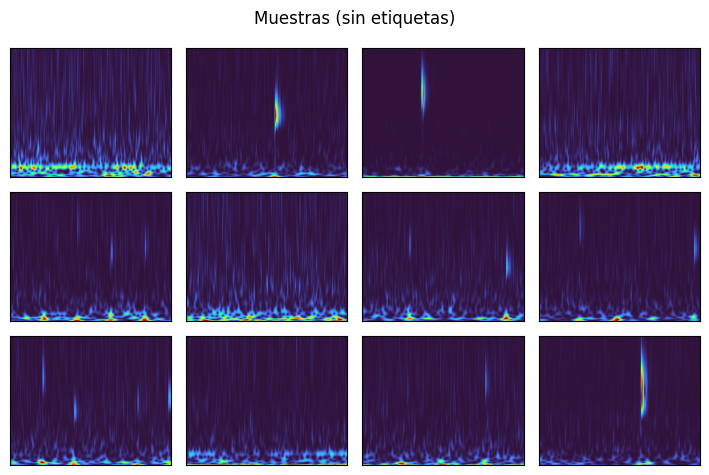

In [64]:
# ============================================================
# 1) DATASET (no supervisado): descubre .npz y carga escalogramas
# ============================================================
DATA_DIR = os.path.join(BASE_DIR, "data")
npz_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.npz")))
if not npz_files:
    raise FileNotFoundError(f"No hay .npz en {DATA_DIR}. ¿Ya corriste 'Scalograms'?")

print(f"[SCAN] .npz encontrados: {len(npz_files)}")
for p in npz_files[:3]: print("  •", p)
if len(npz_files) > 3: print("  • …")

class NPZManifest:
    """Escanea .npz → total de ventanas, HxW, y mapeo índice global → (archivo, índice local)."""
    def __init__(self, files):
        self.files = list(files)
        self.counts, self.cumcounts = [], [0]
        self.img_h = None; self.img_w = None
        for p in self.files:
            d = np.load(p, allow_pickle=True)
            X = d["X"]  # (B,H,W)
            B, H, W = X.shape
            self.counts.append(B)
            self.cumcounts.append(self.cumcounts[-1] + B)
            if self.img_h is None:
                self.img_h, self.img_w = int(H), int(W)
            else:
                if (self.img_h, self.img_w) != (int(H), int(W)):
                    raise ValueError(f"Tamaños inconsistentes: {p} {(H,W)} vs {(self.img_h,self.img_w)}")
        self.total = self.cumcounts[-1]

    def __len__(self): return self.total

    def locate(self, global_idx):
        file_idx = bisect.bisect_right(self.cumcounts, global_idx) - 1
        local_idx = global_idx - self.cumcounts[file_idx]
        return self.files[file_idx], int(local_idx)

manifest = NPZManifest(npz_files)
print(f"[MANIFEST] Ventanas={len(manifest)} | HxW={manifest.img_h}x{manifest.img_w}")

# Estimar si conviene precargar
est_gb = sizeof_gb(len(manifest), manifest.img_h, manifest.img_w, bytes_per=2)  # float16
do_preload = PRELOAD_DATA and (est_gb <= PRELOAD_MAX_GB + 1e-9)
print(f"[MEM] ~{est_gb:.2f} GB | Preload={do_preload} (umbral={PRELOAD_MAX_GB} GB)")

class ScalogramUnsupervisedDS(Dataset):
    """Devuelve (x, '_') con x → tensor (1,H,W) en [0,1]. Sin etiquetas."""
    def __init__(self, manifest: NPZManifest, preload=False, normalize_again=False):
        self.manifest = manifest
        self.normalize_again = normalize_again
        self.preload = preload
        self.cache = {}
        if self.preload:
            print("[LOAD] Precargando .npz a RAM…")
            for p in tqdm(self.manifest.files, desc="Precarga"):
                self.cache[p] = np.load(p, allow_pickle=True)["X"]  # (B,H,W) float16

    def __len__(self): return len(self.manifest)

    def __getitem__(self, i):
        p, j = self.manifest.locate(i)
        Xj = self.cache[p][j] if p in self.cache else np.load(p, allow_pickle=True)["X"][j]
        x = torch.from_numpy(np.asarray(Xj, dtype=np.float32)).unsqueeze(0)  # (1,H,W)
        if IMG_NORMALIZE_AGAIN:
            mn, mx = x.min(), x.max()
            x = (x - mn) / (mx - mn + 1e-12)
            x.clamp_(0.0, 1.0)
        return x, "_"  # placeholder sin etiquetas

# Instanciar dataset y splits 80/20
ds_all = ScalogramUnsupervisedDS(manifest, preload=do_preload, normalize_again=IMG_NORMALIZE_AGAIN)
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(ds_all))
n_tr = int(0.8 * len(ds_all))
idx_tr, idx_va = perm[:n_tr], perm[n_tr:]

ds_train = Subset(ds_all, idx_tr)
ds_val   = Subset(ds_all, idx_va)

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH_AE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
dl_val   = DataLoader(ds_val, batch_size=BATCH_AE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
def make_all_loader(ds, bs=BATCH_EMB):
    return DataLoader(ds, batch_size=bs, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
dl_all = make_all_loader(ds_all, bs=BATCH_EMB)

print(f"[DATA] Train={len(ds_train)} | Val={len(ds_val)} | Total={len(ds_all)} | HxW={manifest.img_h}x{manifest.img_w}")

def show_grid_samples(dataset, n=12, rows=3, cols=4, title="Muestras (sin etiquetas)"):
    n = min(n, len(dataset), rows*cols)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.6*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)
    idxs = rng.choice(len(dataset), size=n, replace=False)
    for k, i in enumerate(idxs):
        x, _ = dataset[i]
        axes[k].imshow(x.squeeze(0).numpy(), origin="lower", aspect="auto", cmap="turbo")
        axes[k].set_xticks([]); axes[k].set_yticks([])
    for a in axes[n:]: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()
show_grid_samples(ds_all)


## **2) Modelo Autoencoder + Capa de Clustering**

In [65]:
# ============================================================
# 2) MODELO (reconstrucción desde parámetros globales)
#     - Usa SIEMPRE BACKBONE y LATENT_DIM actuales
#     - Limpia objetos previos para evitar "estado viejo"
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

# --- helpers de arquitectura ---
def make_channels(backbone: str):
    if backbone == "small": return [32, 64, 128, 256]
    if backbone == "large": return [64, 128, 256, 512]
    return [32, 64, 128, 256]  # 'base'

class ConvEncoder(nn.Module):
    def __init__(self, img_size, latent_dim, dropout_p, backbone):
        super().__init__()
        C = make_channels(backbone)
        self.stem = nn.Sequential(
            nn.Conv2d(1,   C[0], 3, 2, 1), nn.BatchNorm2d(C[0]), nn.ReLU(inplace=True),
            nn.Conv2d(C[0],C[1], 3, 2, 1), nn.BatchNorm2d(C[1]), nn.ReLU(inplace=True),
            nn.Conv2d(C[1],C[2], 3, 2, 1), nn.BatchNorm2d(C[2]), nn.ReLU(inplace=True),
            nn.Conv2d(C[2],C[3], 3, 2, 1), nn.BatchNorm2d(C[3]), nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_p)
        )
        H, W = img_size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, H, W)
            f = self.stem(dummy)                  # (1, C[-1], H', W')
        c_last, h_last, w_last = f.shape[1], f.shape[2], f.shape[3]
        self.flatten_dim = c_last * h_last * w_last
        self.proj = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        f = self.stem(x)
        z = self.proj(f.flatten(1))
        return z

class ConvDecoder(nn.Module):
    def __init__(self, feat_shape, latent_dim, dropout_p, backbone):
        super().__init__()
        C = make_channels(backbone)
        c_last, h_last, w_last = feat_shape[1], feat_shape[2], feat_shape[3]
        self.fc = nn.Linear(latent_dim, c_last * h_last * w_last)
        self.head = nn.Sequential(
            nn.ConvTranspose2d(c_last, C[2], 4, 2, 1), nn.BatchNorm2d(C[2]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[2], C[1], 4, 2, 1),   nn.BatchNorm2d(C[1]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[1], C[0], 4, 2, 1),   nn.BatchNorm2d(C[0]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[0], 1,     4, 2, 1),
            nn.Sigmoid()
        )
        self._feat_shape = (1, c_last, h_last, w_last)

    def forward(self, z):
        f = self.fc(z).view(z.size(0), *self._feat_shape[1:])
        xrec = self.head(f)
        return xrec

class ConvAutoencoder(nn.Module):
    def __init__(self, img_size, latent_dim, dropout_p, backbone):
        super().__init__()
        self.encoder = ConvEncoder(img_size, latent_dim, dropout_p, backbone)
        self.decoder = ConvDecoder(self.encoder.stem(torch.zeros(1,1,*img_size)).shape,
                                   latent_dim, dropout_p, backbone)
        # NOTA: el shape para decoder se deriva del encoder recién creado

    def forward(self, x):
        z  = self.encoder(x)
        xr = self.decoder(z)
        return z, xr

class ClusteringLayer(nn.Module):
    """Capa de clustering con kernel t-Student (DEC)."""
    def __init__(self, n_clusters, latent_dim, alpha=1.0):
        super().__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    @torch.no_grad()
    def set_centers(self, centers_np):
        self.cluster_centers.copy_(torch.as_tensor(centers_np, dtype=torch.float32))

    def forward(self, z):
        z_exp  = z.unsqueeze(1)                       # (B,1,L)
        mu_exp = self.cluster_centers.unsqueeze(0)    # (1,K,L)
        dist2  = torch.sum((z_exp - mu_exp)**2, dim=2)
        num    = (1.0 + dist2 / self.alpha) ** (-(self.alpha + 1.0)/2.0)
        q      = num / torch.sum(num, dim=1, keepdim=True)
        return q

# ------- (1) LIMPIEZA de objetos previos -------
for name in ["ae", "cluster_layer"]:
    if name in globals():
        try:
            obj = globals()[name]
            del obj
        except:
            pass
        globals().pop(name, None)
torch.cuda.empty_cache(); gc.collect()

# ------- (2) RECONSTRUCCIÓN con parámetros ACTUALES -------
IMG_H, IMG_W = manifest.img_h, manifest.img_w
ae = ConvAutoencoder(img_size=(IMG_H, IMG_W),
                     latent_dim=LATENT_DIM,
                     dropout_p=DROPOUT_P,
                     backbone=BACKBONE).to(DEVICE)

# ClusteringLayer inicial con K mínimo (se reemplaza en Celda 4)
cluster_layer = ClusteringLayer(n_clusters=max(2, K_MIN),
                                latent_dim=LATENT_DIM,
                                alpha=1.0).to(DEVICE)

# ------- (3) FINGERPRINT de la arquitectura -------
C = make_channels(BACKBONE)
with torch.no_grad():
    dummy = torch.zeros(1,1,IMG_H,IMG_W).to(DEVICE)
    f = ae.encoder.stem(dummy)  # (1, C[-1], H', W')
flat_dim = ae.encoder.flatten_dim
print("=== Modelo reconstruido ===")
print(f"BACKBONE     : {BACKBONE}  -> canales {C}")
print(f"LATENT_DIM   : {LATENT_DIM}")
print(f"Flatten dim  : {flat_dim}")
print(f"AE params    : {sum(p.numel() for p in ae.parameters() if p.requires_grad):,}")
print(f"Clus params  : {sum(p.numel() for p in cluster_layer.parameters() if p.requires_grad):,}")

# ------- (4) Sanity check -------
xb, _ = next(iter(dl_train))
xb = xb.to(DEVICE, non_blocking=True)
with torch.no_grad():
    z, xr = ae(xb)
print(f"[CHECK] input {tuple(xb.shape)} → z {tuple(z.shape)} → recon {tuple(xr.shape)}")
assert z.shape[1] == LATENT_DIM, "LATENT_DIM no coincide (¿no se reconstruyó el modelo?)"

=== Modelo reconstruido ===
BACKBONE     : large  -> canales [64, 128, 256, 512]
LATENT_DIM   : 256
Flatten dim  : 131072
AE params    : 71,546,817
Clus params  : 768
[CHECK] input (64, 1, 256, 256) → z (64, 256) → recon (64, 1, 256, 256)


## **3. Pre-entrenamiento del AutoEncoder + extracción de embeddings (Z)**

[AE] ep 01/25 | train=0.2381 | val=0.0998 | lr=1.00e-03 | 2.8s


[AE] ep 02/25 | train=0.1149 | val=0.0862 | lr=1.00e-03 | 2.7s


[AE] ep 03/25 | train=0.0747 | val=0.0347 | lr=1.00e-03 | 2.7s


[AE] ep 04/25 | train=0.0272 | val=0.0217 | lr=1.00e-03 | 2.7s


[AE] ep 05/25 | train=0.0203 | val=0.0198 | lr=1.00e-03 | 2.7s


[AE] ep 06/25 | train=0.0168 | val=0.0160 | lr=1.00e-03 | 2.7s


[AE] ep 07/25 | train=0.0151 | val=0.0154 | lr=1.00e-03 | 2.7s


[AE] ep 08/25 | train=0.0148 | val=0.0152 | lr=1.00e-03 | 2.7s


[AE] ep 09/25 | train=0.0147 | val=0.0150 | lr=1.00e-03 | 2.7s


[AE] ep 10/25 | train=0.0145 | val=0.0149 | lr=1.00e-03 | 2.7s


[AE] ep 11/25 | train=0.0144 | val=0.0148 | lr=1.00e-03 | 2.7s


[AE] ep 12/25 | train=0.0144 | val=0.0148 | lr=1.00e-03 | 2.7s


[AE] ep 13/25 | train=0.0142 | val=0.0146 | lr=1.00e-03 | 2.7s


[AE] ep 14/25 | train=0.0141 | val=0.0146 | lr=1.00e-03 | 2.7s


[AE] ep 15/25 | train=0.0140 | val=0.0145 | lr=1.00e-03 | 2.7s


[AE] ep 16/25 | train=0.0140 | val=0.0145 | lr=1.00e-03 | 2.7s


[AE] ep 17/25 | train=0.0140 | val=0.0145 | lr=1.00e-03 | 2.7s


[AE] ep 18/25 | train=0.0139 | val=0.0144 | lr=1.00e-03 | 2.7s


[AE] ep 19/25 | train=0.0139 | val=0.0144 | lr=1.00e-03 | 2.7s


[AE] ep 20/25 | train=0.0139 | val=0.0143 | lr=1.00e-03 | 2.7s


[AE] ep 21/25 | train=0.0138 | val=0.0143 | lr=1.00e-03 | 2.7s


[AE] ep 22/25 | train=0.0137 | val=0.0142 | lr=1.00e-03 | 2.7s


[AE] ep 23/25 | train=0.0137 | val=0.0142 | lr=1.00e-03 | 2.7s


[AE] ep 24/25 | train=0.0136 | val=0.0140 | lr=1.00e-03 | 2.7s


[AE] ep 25/25 | train=0.0134 | val=0.0139 | lr=1.00e-03 | 2.7s


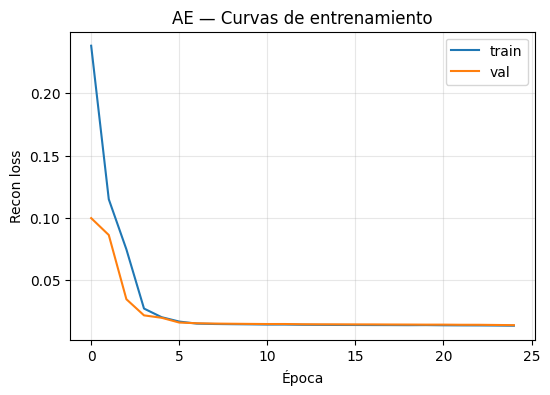

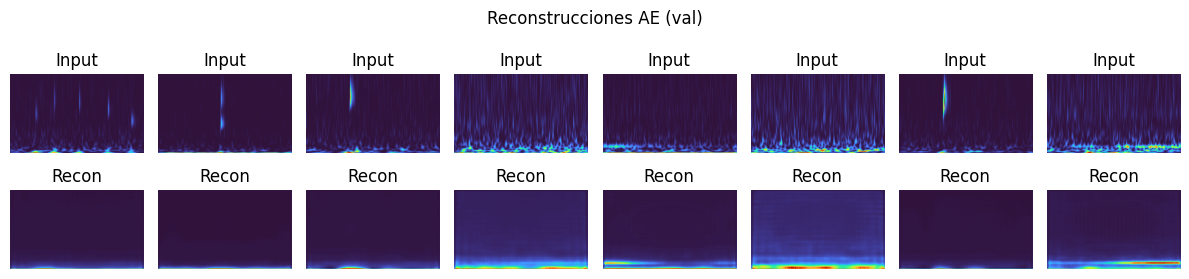

Embeddings Z_all: (1800, 256)


In [66]:
# ============================================================
# 3) PREENTRENAMIENTO DEL AE (AMP nueva API) + EXTRACCIÓN DE Z
# ============================================================
import gc, time
from contextlib import nullcontext

def _amp_enabled():
    return bool(USE_AMP and DEVICE.type == "cuda")

def _amp_ctx():
    # API nueva: torch.amp.autocast('cuda', ...)
    return torch.amp.autocast("cuda", dtype=torch.float16) if _amp_enabled() else nullcontext()

def _make_scaler():
    # API nueva: torch.amp.GradScaler('cuda')
    return torch.amp.GradScaler("cuda") if _amp_enabled() else None

def train_autoencoder(
    ae, dl_train, dl_val,
    epochs=AE_EPOCHS, lr=AE_LR, wd=AE_WD,
    use_amp=USE_AMP, loss_name=AE_LOSS, device=DEVICE,
):
    ae = ae.to(device).train()
    opt = torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=4)
    criterion = nn.MSELoss() if str(loss_name).lower()=="mse" else nn.L1Loss()

    scaler = _make_scaler()
    hist = {"train": [], "val": [], "lr": []}
    best_val, best_state = float("inf"), None

    for ep in range(1, epochs+1):
        t0 = time.time()

        # ---------- TRAIN ----------
        ae.train(); tr_loss, ntr = 0.0, 0
        for xb, _ in tqdm(dl_train, desc=f"[AE][{ep:02d}/{epochs}] Train", leave=False):
            xb = xb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with _amp_ctx():
                z, xr = ae(xb)
                loss = criterion(xr, xb)

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                loss.backward(); opt.step()

            tr_loss += loss.item()*xb.size(0); ntr += xb.size(0)
        tr_loss /= max(1, ntr)

        # ---------- VAL ----------
        ae.eval(); va_loss, nva = 0.0, 0
        with torch.no_grad():
            for xb, _ in tqdm(dl_val, desc=f"[AE][{ep:02d}/{epochs}] Val  ", leave=False):
                xb = xb.to(device, non_blocking=True)
                with _amp_ctx():
                    _, xr = ae(xb)
                    vl = criterion(xr, xb)
                va_loss += vl.item()*xb.size(0); nva += xb.size(0)
        va_loss /= max(1, nva)

        # Scheduler y log
        prev_lr = opt.param_groups[0]["lr"]
        scheduler.step(va_loss)
        lr_now = opt.param_groups[0]["lr"]
        if lr_now < prev_lr:
            print(f"   ↘ LR: {prev_lr:.2e} → {lr_now:.2e}")

        hist["train"].append(tr_loss); hist["val"].append(va_loss); hist["lr"].append(lr_now)
        print(f"[AE] ep {ep:02d}/{epochs} | train={tr_loss:.4f} | val={va_loss:.4f} | lr={lr_now:.2e} | {time.time()-t0:.1f}s")

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k:v.detach().cpu().clone() for k,v in ae.state_dict().items()}

        torch.cuda.empty_cache(); gc.collect()

    if best_state is not None:
        ae.load_state_dict(best_state)
    return ae, hist

# --- Entrenar AE ---
ae, hist_ae = train_autoencoder(ae, dl_train, dl_val,
                                epochs=AE_EPOCHS, lr=AE_LR, wd=AE_WD,
                                use_amp=USE_AMP, loss_name=AE_LOSS, device=DEVICE)

# --- Curvas ---
plt.figure(figsize=(6,4))
plt.plot(hist_ae["train"], label="train")
plt.plot(hist_ae["val"], label="val")
plt.xlabel("Época"); plt.ylabel("Recon loss"); plt.title("AE — Curvas de entrenamiento")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# --- Reconstrucciones rápidas ---
ae.eval()
with torch.no_grad():
    xb, _ = next(iter(dl_val))
    xb = xb.to(DEVICE, non_blocking=True)
    _, xr = ae(xb[:8])
xb = xb[:8].cpu().numpy(); xr = xr.cpu().numpy()

rows, cols = 2, min(8, xb.shape[0])
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2.8))
for i in range(cols):
    axes[0, i].imshow(xb[i,0], origin="lower", aspect="auto", cmap="turbo"); axes[0, i].set_title("Input");  axes[0, i].axis("off")
    axes[1, i].imshow(xr[i,0], origin="lower", aspect="auto", cmap="turbo"); axes[1, i].set_title("Recon");  axes[1, i].axis("off")
plt.suptitle("Reconstrucciones AE (val)"); plt.tight_layout(); plt.show()

# --- Extracción de Z (todo el set) con AMP nueva API ---
@torch.no_grad()
def extract_embeddings(encoder, dl, device=DEVICE):
    encoder.eval(); Z_list = []
    for xb, _ in tqdm(dl, desc="[Z] Extract", leave=False):
        xb = xb.to(device, non_blocking=True)
        with _amp_ctx():
            z = encoder(xb)
        Z_list.append(z.detach().cpu().numpy())
    return np.concatenate(Z_list, axis=0)

Z_all = extract_embeddings(ae.encoder, dl_all, device=DEVICE)
print("Embeddings Z_all:", Z_all.shape)


## **4) Barrido de K + KMeans + Inicialización + DEC**


=== Barrido K (robusto, métricas en Z estabilizado) ===
 K |  Sil(mean)±std |  CH_log(mean)±std |  DB(mean)±std 
 3 |  0.2911±0.0000 |       6.4020±0.0000 |  1.4574±0.0001
 4 |  0.2593±0.0037 |       6.1697±0.0024 |  1.9985±0.0621
 5 |  0.2551±0.0068 |       6.0249±0.0112 |  1.9188±0.0185
 6 |  0.2523±0.0091 |       5.9248±0.0097 |  1.8446±0.0483
 7 |  0.2467±0.0092 |       5.8313±0.0257 |  1.8215±0.0720
 8 |  0.2378±0.0180 |       5.7510±0.0247 |  1.8158±0.0906
 9 |  0.2372±0.0157 |       5.6940±0.0086 |  1.7661±0.0489
10 |  0.2361±0.0241 |       5.6344±0.0136 |  1.7310±0.0983

→ K* (robusto, métricas) = 3
[INIT] Centros iniciales fijados (K=3)
[DEC] ep 01  sil=0.0752 ch=186.5 db=2.8129


[DEC] ep 02  Δasig=0.0506 | sil=0.0851 ch=232.1 db=2.9935


[DEC] ep 03  Δasig=0.0239 | sil=0.0812 ch=254.5 db=2.9931


[DEC] ep 04  Δasig=0.0067 | sil=0.0762 ch=260.6 db=2.8442


[DEC] ep 05  Δasig=0.0117 | sil=0.0813 ch=275.1 db=2.5867


[DEC] ep 06  Δasig=0.0072 | sil=0.0828 ch=284.1 db=2.3852


[DEC] ep 07  Δasig=0.0161 | sil=0.0878 ch=304.9 db=2.0499


[DEC] ep 08  Δasig=0.0061 | sil=0.0873 ch=310.5 db=1.8025


[DEC] ep 09  Δasig=0.0100 | sil=0.0886 ch=322.2 db=1.6990


[DEC] ep 10  Δasig=0.0044 | sil=0.0903 ch=329.8 db=1.5834


[DEC] ep 11  Δasig=0.0089 | sil=0.0956 ch=350.8 db=1.4519


[DEC] ep 12  Δasig=0.0117 | sil=0.1016 ch=377.6 db=1.4023


[DEC] ep 13  Δasig=0.0117 | sil=0.1024 ch=354.2 db=1.3215


[DEC] ep 14  Δasig=0.0100 | sil=0.1036 ch=379.7 db=1.2996


[DEC] ep 15  Δasig=0.0139 | sil=0.1221 ch=407.0 db=1.2063


[DEC] ep 16  Δasig=0.0056 | sil=0.1214 ch=406.3 db=1.1444


[DEC] ep 17  Δasig=0.0194 | sil=0.1328 ch=436.7 db=1.1213


[DEC] ep 18  Δasig=0.0106 | sil=0.1406 ch=441.0 db=1.0315


[DEC] ep 19  Δasig=0.0117 | sil=0.1482 ch=452.4 db=1.0112


[DEC] ep 20  Δasig=0.0194 | sil=0.1820 ch=528.6 db=0.9104


[DEC] ep 21  Δasig=0.0289 | sil=0.2082 ch=631.0 db=0.9032


[DEC] ep 22  Δasig=0.0194 | sil=0.2480 ch=736.4 db=0.8071


[DEC] ep 23  Δasig=0.0150 | sil=0.2602 ch=785.9 db=0.7894


[DEC] ep 24  Δasig=0.0161 | sil=0.2839 ch=880.9 db=0.7572


[DEC] ep 25  Δasig=0.0322 | sil=0.3145 ch=1013.3 db=0.7277


[DEC] ep 26  Δasig=0.0106 | sil=0.3595 ch=1219.1 db=0.6724


[DEC] ep 27  Δasig=0.0106 | sil=0.3338 ch=1135.5 db=0.6978


[DEC] ep 28  Δasig=0.0294 | sil=0.4044 ch=1472.6 db=0.6278


[DEC] ep 29  Δasig=0.0256 | sil=0.4492 ch=1734.4 db=0.5823


[DEC] ep 30  Δasig=0.0100 | sil=0.4561 ch=1801.8 db=0.5844


[DEC] ep 31  Δasig=0.0083 | sil=0.4422 ch=1646.9 db=0.5690


[DEC] ep 32  Δasig=0.0033 | sil=0.4405 ch=1628.0 db=0.5645


[DEC] ep 33  Δasig=0.0078 | sil=0.4661 ch=1816.1 db=0.5479


[DEC] ep 34  Δasig=0.0194 | sil=0.4849 ch=1940.9 db=0.5409


[DEC] ep 35  Δasig=0.0106 | sil=0.5053 ch=2041.2 db=0.5109


[DEC] ep 36  Δasig=0.0017 | sil=0.5093 ch=2033.2 db=0.4969


[DEC] ep 37  Δasig=0.0089 | sil=0.5350 ch=2280.6 db=0.4802


[DEC] ep 38  Δasig=0.0094 | sil=0.5384 ch=2385.3 db=0.4851


[DEC] ep 39  Δasig=0.0106 | sil=0.5502 ch=2543.5 db=0.4830


[DEC] ep 40  Δasig=0.0056 | sil=0.5512 ch=2594.5 db=0.4874


[DEC] Clusters finales: {0: 1024, 2: 454, 1: 322}
[DEC] Final (métricas en Z estabilizado): Sil=0.5490 | CH=2519.3 | DB=0.4756


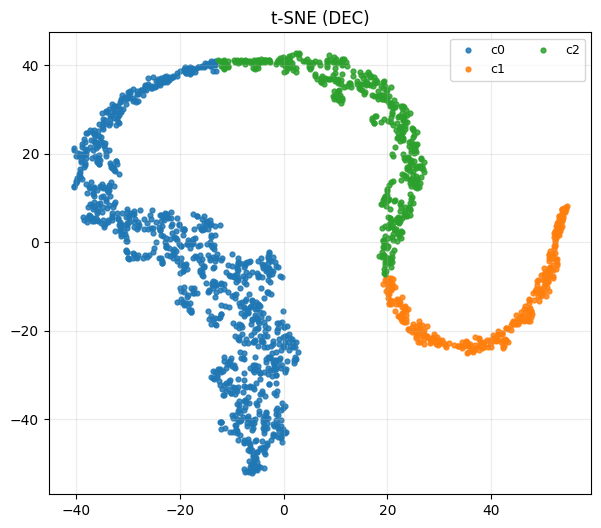

In [67]:
# ============================================================
# 4) BARRIDO DE K (robusto) → Inicializar centros → Entrenar DEC
#     - TODO el dataset (sin muestreo)
#     - Métricas en Z estabilizado (RobustScaler + L2 + float64)
#     - KMeans con n_init/max_iter explícitos
#     - AMP (API nueva) para DEC
# ============================================================
from contextlib import nullcontext
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import RobustScaler, normalize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --- AMP helpers (reusa firma de Celda 3) ---
def _amp_enabled():
    return bool(USE_AMP and DEVICE.type == "cuda")

def _amp_ctx():
    return torch.amp.autocast("cuda", dtype=torch.float16) if _amp_enabled() else nullcontext()

def _make_scaler():
    return torch.amp.GradScaler("cuda") if _amp_enabled() else None

# --- utilidades ---
def _stabilize_for_metrics(Z_in: np.ndarray) -> np.ndarray:
    """Para métricas internas: robust scale + L2 row-norm + float64."""
    Z = np.asarray(Z_in, dtype=np.float64)
    Z = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5, 95)).fit_transform(Z)
    Z = normalize(Z, norm='l2')
    return Z

def _safe_metric(fn, *args):
    try:
        return fn(*args)
    except Exception:
        return float('nan')

def make_kmeans(n_clusters, random_state=0, n_init_opt=None, max_iter=800):
    """KMeans compatible con distintas versiones y más iteraciones."""
    try:
        n_init = "auto" if n_init_opt is None else n_init_opt
        return KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init, max_iter=max_iter)
    except TypeError:
        n_init = 50 if n_init_opt is None else n_init_opt
        return KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init, max_iter=max_iter)

def show_tsne(Z, y, title="t-SNE (Z)"):
    if not RUN_TSNE_2D: return
    Z = np.asarray(Z, dtype=np.float64)
    n = Z.shape[0]
    if n < 10:
        print("t-SNE omitido (muy pocas muestras)."); return
    perp = max(5, min(TSNE_PERPLEXITY, (n - 1) // 3))
    Z2 = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate="auto",
        init="pca",
        max_iter=1000,
        angle=0.5,
        method="barnes_hut",
        metric="euclidean",
        random_state=SEED,
        verbose=0
    ).fit_transform(Z)
    plt.figure(figsize=(7,6))
    for k in sorted(np.unique(y)):
        idx = (y == k)
        plt.scatter(Z2[idx,0], Z2[idx,1], s=12, alpha=0.85, label=f"c{k}")
    plt.title(title); plt.grid(True, alpha=0.25); plt.legend(ncol=2, fontsize=9)
    plt.show()

# ------------------------------------------------------------
# 4A) Barrido de K ROBUSTO (Sil/CH/DB) usando TODO el dataset
# ------------------------------------------------------------
def sweep_k_robust(Z_all_raw,
                   ks=range(K_MIN, K_MAX+1),
                   repeats=7,
                   base_seed=K_RANDOM_STATE):
    """
    - Usa Z estabilizado para evaluar métricas (evita overflows/NaN).
    - Repite KMeans 'repeats' veces por K y promedia métricas.
    - Penaliza inestabilidad (desviación estándar entre semillas).
    """
    Z_raw   = np.ascontiguousarray(np.asarray(Z_all_raw, dtype=np.float64))
    Z_estab = _stabilize_for_metrics(Z_raw)

    print("\n=== Barrido K (robusto, métricas en Z estabilizado) ===")
    print(" K |  Sil(mean)±std |  CH_log(mean)±std |  DB(mean)±std ")

    rows = []
    for k in ks:
        sils, chs, dbs = [], [], []
        for r in range(repeats):
            seed = int(base_seed + 9973*r)
            km = make_kmeans(k, random_state=seed)  # n_init y max_iter explícitos
            labels = km.fit_predict(Z_estab)

            # Si KMeans colapsa a <k clusters, declaramos corrida inválida (NaN)
            if len(np.unique(labels)) < k:
                sil, ch, db = np.nan, np.nan, np.nan
            else:
                sil = silhouette_score(Z_estab, labels, metric="euclidean")
                ch  = calinski_harabasz_score(Z_estab, labels)
                db  = davies_bouldin_score(Z_estab, labels)

            sils.append(sil); chs.append(ch); dbs.append(db)

        sil_mean, sil_std = (np.nanmean(sils), np.nanstd(sils))
        ch_mean,  ch_std  = (np.nanmean(chs),  np.nanstd(chs))
        db_mean,  db_std  = (np.nanmean(dbs),  np.nanstd(dbs))
        ch_log_mean = np.log1p(ch_mean) if np.isfinite(ch_mean) and ch_mean > 0 else np.nan
        ch_log_std  = (np.nan if not (np.isfinite(ch_std) and ch_mean > 0)
                       else ch_std / (1.0 + ch_mean))
        print(f"{k:2d} | {sil_mean:>7.4f}±{sil_std:<6.4f} | {ch_log_mean:>12.4f}±{(0.0 if np.isnan(ch_log_std) else ch_log_std):<6.4f} | {db_mean:>7.4f}±{db_std:<6.4f}")

        rows.append({
            "k": k,
            "sil_mean": sil_mean, "sil_std": sil_std,
            "ch_log_mean": ch_log_mean, "ch_log_std": (np.nan if np.isnan(ch_log_std) else ch_log_std),
            "db_mean": db_mean, "db_std": db_std
        })

    # z-score robusto + penalización por inestabilidad entre semillas
    def _z(x):
        x = np.array(x, dtype=np.float64)
        m, s = np.nanmean(x), np.nanstd(x)
        if not np.isfinite(s) or s < 1e-12: return np.zeros_like(x)
        z = (x - m) / s; z[~np.isfinite(z)] = 0.0; return z

    K_vals   = np.array([r["k"] for r in rows])
    sil_mu   = np.array([r["sil_mean"] for r in rows], dtype=np.float64)
    chlog_mu = np.array([r["ch_log_mean"] for r in rows], dtype=np.float64)
    db_mu    = np.array([r["db_mean"] for r in rows], dtype=np.float64)
    sil_sd   = np.array([r["sil_std"] for r in rows], dtype=np.float64)
    chlog_sd = np.array([r["ch_log_std"] for r in rows], dtype=np.float64)
    db_sd    = np.array([r["db_std"] for r in rows], dtype=np.float64)

    score = _z(sil_mu) + _z(chlog_mu) + _z(-db_mu) + 0.5*(_z(-sil_sd) + _z(-chlog_sd) + _z(-db_sd))
    k_star_metrics = int(K_vals[int(np.nanargmax(score))])
    return {"k": k_star_metrics, "Z_raw": Z_raw, "Z_estab": Z_estab, "rows": rows}

# --- usar el barrido robusto (toda la población, multi-semillas) ---
ks_range   = range(K_MIN, K_MAX+1)  # o range(3, 11) si prefieres fijarlo aquí
res_metrics= sweep_k_robust(Z_all, ks=ks_range, repeats=7, base_seed=K_RANDOM_STATE)
K_OPT      = int(res_metrics["k"])
Z_raw      = res_metrics["Z_raw"]   # espacio real para inicializar centros

print(f"\n→ K* (robusto, métricas) = {K_OPT}")

# ------------------------------------------------------------
# 4B) Inicializar centros en Z_raw y crear ClusteringLayer
# ------------------------------------------------------------
kmeans_raw = make_kmeans(K_OPT, random_state=K_RANDOM_STATE, n_init_opt=50, max_iter=800)
kmeans_raw.fit(Z_raw)
centers = kmeans_raw.cluster_centers_

cluster_layer = ClusteringLayer(n_clusters=K_OPT, latent_dim=LATENT_DIM, alpha=1.0).to(DEVICE)
cluster_layer.set_centers(centers)
print(f"[INIT] Centros iniciales fijados (K={K_OPT})")

# ------------------------------------------------------------
# 4C) DEC: Q/P, entrenamiento (KL), métricas y t-SNE
# ------------------------------------------------------------
class IndexDataset(Dataset):
    def __init__(self, base): self.base = base
    def __len__(self): return len(self.base)
    def __getitem__(self, i): x, _ = self.base[i]; return x, i

def make_index_loader(ds, bs=BATCH_DEC, shuffle=True):
    return DataLoader(IndexDataset(ds), batch_size=bs, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS > 0 and PERSISTENT_WORKERS),
                      drop_last=False)

dl_all_ordered  = make_index_loader(ds_all, bs=BATCH_DEC, shuffle=False)
dl_all_shuffled = make_index_loader(ds_all, bs=BATCH_DEC, shuffle=True)

@torch.no_grad()
def compute_q_all(encoder, cl_layer, dl_ordered, device=DEVICE):
    encoder.eval(); cl_layer.eval()
    Qs, Zs = [], []
    for xb, idx in dl_ordered:
        xb = xb.to(device, non_blocking=True)
        with _amp_ctx():
            z = encoder(xb)
            q = cl_layer(z)
        q = torch.clamp(q, 1e-8, 1.0); q = q / q.sum(dim=1, keepdim=True)
        Qs.append(q.detach().cpu()); Zs.append(z.detach().cpu())
    Q = torch.cat(Qs, dim=0).numpy()
    Z = torch.cat(Zs, dim=0).numpy()
    return Q, Z

def target_distribution(Q_torch):
    weight = (Q_torch ** 2) / torch.sum(Q_torch, dim=0, keepdim=True)
    P = weight / torch.sum(weight, dim=1, keepdim=True)
    P = torch.clamp(P, 1e-8, 1.0); P = P / P.sum(dim=1, keepdim=True)
    return P

def cluster_metrics(Z_raw_np, y):
    Zm = _stabilize_for_metrics(Z_raw_np)
    sil = _safe_metric(silhouette_score, Zm, y)
    ch  = _safe_metric(calinski_harabasz_score, Zm, y)
    db  = _safe_metric(davies_bouldin_score, Zm, y)
    return sil, ch, db

def dec_train(ae, cl_layer, dl_ordered, dl_shuffled,
              epochs=DEC_EPOCHS, lr=DEC_LR, wd=DEC_WD,
              update_interval=DEC_UPDATE_INT, tol=DEC_TOL,
              use_amp=USE_AMP, device=DEVICE):
    ae.encoder.to(device); cl_layer.to(device)
    opt = torch.optim.AdamW(list(ae.encoder.parameters()) + list(cl_layer.parameters()), lr=lr, weight_decay=wd)
    scaler = _make_scaler()
    history = {"kl": [], "silhouette": [], "ch": [], "db": []}
    y_prev = None

    for ep in range(1, epochs+1):
        # E: Q y P en TODO el set + métricas (en Z estabilizado)
        Q_np, Z_raw_np = compute_q_all(ae.encoder, cl_layer, dl_ordered, device)
        Q = torch.from_numpy(Q_np)
        P = target_distribution(Q)
        y_curr = Q_np.argmax(axis=1)
        sil, ch, db = cluster_metrics(Z_raw_np, y_curr)
        history["silhouette"].append(sil); history["ch"].append(ch); history["db"].append(db)

        if y_prev is not None:
            delta = (y_prev != y_curr).sum() / float(len(y_curr))
            print(f"[DEC] ep {ep:02d}  Δasig={delta:.4f} | sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
            if delta < tol and ep > 5:
                print("[DEC] Convergencia por estabilidad."); break
        else:
            print(f"[DEC] ep {ep:02d}  sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
        y_prev = y_curr

        # M: KL(P||Q)
        ae.encoder.train(); cl_layer.train()
        kl_epoch, n_batches = 0.0, 0
        for xb, idx in tqdm(dl_all_shuffled, desc=f"[DEC][{ep:02d}/{epochs}] KL", leave=False):
            xb  = xb.to(device, non_blocking=True); idx = idx.long()
            with _amp_ctx():
                z = ae.encoder(xb)
                q = cl_layer(z)
                q = torch.clamp(q, 1e-8, 1.0); q = q / q.sum(dim=1, keepdim=True)
                p = P[idx].to(device)
                loss = F.kl_div(q.log(), p, reduction="batchmean")

            if scaler is not None:
                opt.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                opt.zero_grad(set_to_none=True)
                loss.backward(); opt.step()

            kl_epoch += loss.item(); n_batches += 1

        history["kl"].append(kl_epoch / max(1, n_batches))
        torch.cuda.empty_cache(); gc.collect()

    Q_final, Z_final = compute_q_all(ae.encoder, cl_layer, dl_ordered, device)
    y_final = Q_final.argmax(axis=1)
    print(f"[DEC] Clusters finales: {dict(Counter(y_final.tolist()))}")
    return {"Q": Q_final, "Z": Z_final, "y": y_final, "history": history}

# --- Ejecutar DEC ---
RESULT_DEC = dec_train(ae, cluster_layer, dl_all_ordered, dl_all_shuffled,
                       epochs=DEC_EPOCHS, lr=DEC_LR, wd=DEC_WD,
                       update_interval=DEC_UPDATE_INT, tol=DEC_TOL,
                       use_amp=USE_AMP, device=DEVICE)

# --- Métricas finales + t-SNE ---
Zm_final = _stabilize_for_metrics(RESULT_DEC["Z"])
sil = _safe_metric(silhouette_score, Zm_final, RESULT_DEC["y"])
ch  = _safe_metric(calinski_harabasz_score, Zm_final, RESULT_DEC["y"])
db  = _safe_metric(davies_bouldin_score,   Zm_final, RESULT_DEC["y"])
print(f"[DEC] Final (métricas en Z estabilizado): Sil={sil:.4f} | CH={ch:.1f} | DB={db:.4f}")

show_tsne(RESULT_DEC["Z"], RESULT_DEC["y"], title="t-SNE (DEC)")
